# Import libraries

In [ ]:
from dataset import FurnitureDataset
from models import *
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import argparse
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import dataset and model

In [115]:
# Define arguments
encoding_dim = 32
img_size = 128
mode = 'encode'
model_name = 'dressers_lamps'

# Device configuration
device = torch.device('cuda')

# Prepare image
furnitures = model_name.split('_')
furniture_dataloader = []
for furniture_type in furnitures:
    dataset = FurnitureDataset(furniture_type, img_size)
    dataloader = DataLoader(dataset)
    furniture_dataloader.append(dataloader)

# Load encoder model
encoder = Encoder(encoding_dim, img_size).to(device)
encoder_path = os.path.join('./weights', f'{model_name}_encoder.pth')
encoder.load_state_dict(torch.load(encoder_path))

# Create latent space
# Create dictionary for each furniture type so that the latent vector distribution can be analyzed separately
latent_vector = [{'vector': [], 'label': []} for _ in range(len(furnitures))]

for furniture_idx, dataloader in enumerate(furniture_dataloader):
    progress = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, data in progress:
        # Encode
        furniture_item = data['item'].to(device)
        furniture_item = furniture_item.view(furniture_item.shape[0], -1)
        furniture_item_encoded = encoder(furniture_item)

        # Populate latent space
        furniture_type = data['type'][0]
        latent_vector[furniture_idx]['vector'].append(furniture_item_encoded.cpu().detach().numpy())
        latent_vector[furniture_idx]['label'].append(furniture_type)

        # Verbose
        progress.set_description(
        f'[{i}/{len(dataloader) - 1}]')

[7/7870]:   0%|                                                                               | 0/7871 [00:00<?, ?it/s]

Loading dressers dataset...
dressers dataset loaded successfully.
Loading lamps dataset...
lamps dataset loaded successfully.


[32401/32401]: 100%|████████████████████████████████████████████████████████████| 32402/32402 [02:56<00:00, 183.18it/s]


# Check the model architecture

In [55]:
print(encoder)
print(decoder)

Encoder(
  (model): Sequential(
    (0): Linear(in_features=49152, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
  )
)
Decoder(
  (model): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=49152, bias=True)
    (5): Sigmoid()
  )
)


# Create a latent space intrapolation gif

In [111]:
img_shape = (latent_vector[0]['vector'][0].shape)
flatten_shape = np.prod(img_shape)

# latent space
latent_vector_np = [np.vstack( latent_vector[i]['vector'] ) for i in range(len(furnitures))]
latent_vector_pd = [pd.DataFrame(data=latent_vector_np[i]) for i in range(len(furnitures))]

# Load decoder model
decoder = Decoder(encoding_dim, img_size).to(device)
decoder_path = os.path.join('./weights', f'{model_name}_decoder.pth')
decoder.load_state_dict(torch.load(decoder_path))

# Input latent vector
vector_i = latent_vector_pd[0].mean()
vector_f = latent_vector_pd[1].mean()
num_vectors = 10
unit_vector = (vector_f-vector_i)/num_vectors

latent_vector_inputs = [torch.from_numpy((vector_i+i*unit_vector).to_numpy()).to(device) for i in range(num_vectors)]

imgs = []
for idx, latent_vector_input in enumerate(latent_vector_inputs):
    output = decoder(latent_vector_input)
    output_reshape = torch.reshape(output, (3, img_size, img_size)).cpu().detach()
    im = transforms.ToPILImage()(output_reshape).convert("RGB")
    imgs.append(im)

imgs[0].save(f'./assets/{model_name}.gif', save_all=True, append_images=imgs[1:], loop=0)
print(f'{model_name}.gif generated!')

dressers_lamps.gif generated!


# Create a latent space visualization with t-SNE

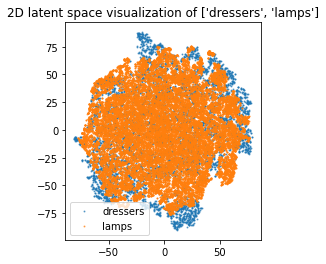

In [116]:
from sklearn.manifold import TSNE

# latent space
latent_vector_np = [np.vstack( latent_vector[i]['vector'] ) for i in range(len(furnitures))]

plt.figure()
for i in range(len(latent_vector_np)):
    latent_vector_embedded = TSNE(n_components=2).fit_transform(latent_vector_np[i])
    plt.scatter(latent_vector_embedded[:, 0], latent_vector_embedded[:, 1], c=f'C{i}', s=1, alpha=0.6, label=furnitures[i])

plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.title(f'2D latent space visualization of {furnitures}')
plt.show()

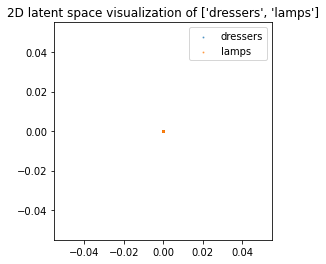

In [112]:
latent_vector_np = [np.vstack( latent_vector[i]['vector'] ) for i in range(len(furnitures))]

plt.figure()
for i in range(len(latent_vector_np)):
    latent_vector_embedded = latent_vector_np[i]
    plt.scatter(latent_vector_embedded[:, 0], latent_vector_embedded[:, 1], c=f'C{i}', s=1, alpha=0.6, label=furnitures[i])

plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.title(f'2D latent space visualization of {furnitures}')
plt.show()